In [1]:
import collections
import requests
import json
import re
import os
import sys
import numpy as np

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for 

# globale items
regex = "{(.*?)}" # hier die genaue Definition der Kommentare vom Parser <<< >>>
kommentare = []

In [2]:
with open('../../data/speeches_20_withcomments.jsonl', 'r', encoding = 'utf8') as fp:
    data = list(fp)
speeches = []
for line in data:
    speeches.append(json.loads(line))
    
    

In [3]:
len(speeches)

2777

In [ ]:
speeches[2776]

In [4]:
# Funktion: speeches_comments
def extract_comments(speeches):
    comments = []
    modified_speeches = []
    for speech in speeches:
        text = speech['text']
        matches = re.findall(regex,text)
        speech['comments'] = matches
        modified_speeches.append(speech)
    return modified_speeches
# Funktionsaufruf:
# speeches_comments = extract_comments(speeches)
# Funktionsausgabe: print(speeches_comments[0]['comments'])
#                   print(speeches_comments[0]['party'])


# Funktion: specific_and_non_search
def filter_with_complex_non_words(search_terms,non_words,speeches):
    filtered_speeches = []
    for speech in speeches:
        for comment in speech['comments']:
            if all([term in comment for term in search_terms]) and not any([term in comment for term in non_words]):
                filtered_speeches.append(speech)
                break
    return filtered_speeches
# Funktionsaufruf:  specific_and_non_search = filter_with_complex_non_words(['Beifall','CDU'],['Zuruf'],speeches_comments)
# Funktionsausgabe: print(specific_and_non_search[0])                               enthält AND enthält nicht
#                   print(len(specific_and_non_search))


# Funktion: speech_of_party
def filter_party (party,speeches):
    speeches_of_party = []
    for speech in speeches:
        if speech['party'] == party:
            speeches_of_party.append(speech)
    return speeches_of_party
# Funktionsaufruf:  filter_of_party = filter_party(['SPD'],speeches)


In [5]:
speeches_comments = extract_comments(speeches)
#speeches_comments




# Marcel. Ich denke die nächsten Zellen solltest du dir anschauen.


In [11]:
all_comments = []
all_comments_zuruf = []
all_comments_beifall = []
all_comments_beifall_zuruf = []

for speech in speeches:
    if len(speech['comments']) > 0:
        for comment in speech['comments']:
            all_comments.append(comment)
            if 'Zuruf' in comment:
                all_comments_zuruf.append(comment)
            if 'Beifall' in comment:
                all_comments_beifall.append(comment) 
            if 'Beifall' in comment and 'Zuruf' in comment:
                all_comments_beifall_zuruf.append(comment)    

print(len(all_comments),len(all_comments_beifall),len(all_comments_zuruf),len(all_comments_beifall_zuruf))



22099 15735 2114 663


# Vor allem das hier!

Es macht einen dict der Struktur:




In [179]:
comments_to = {
             'BÜNDNIS 90/DIE GRÜNEN' : ['all comments to Grüne'], 
             'CDU/CSU'               : ['all comments to '],
             'Fraktionslos'          : ['all comments to '],
             'AfD'                   : ['all comments to '],
             'SPD'                   : ['all comments to '],
             'FDP'                   : ['all comments to '],
             'DIE LINKE'             : ['all comments to ']
}

## das für die Partynames

In [24]:
# get party names

def clean_partyname(speeches):
    for speech in speeches:
        if 'BÜNDNIS\xa090/DIE GRÜNEN' in speech['party']:
            speech.update({'party': 'BÜNDNIS 90/DIE GRÜNEN'})
clean_partyname(speeches)

party_names = []
for speech in speeches:
    if speech['party'] in party_names:
        pass
    else:
        party_names.append(speech['party'])
        
party_names

['BÜNDNIS 90/DIE GRÜNEN',
 'CDU/CSU',
 'Fraktionslos',
 'AfD',
 'SPD',
 'FDP',
 'DIE LINKE']

# Auch wichtig: 
### diese Funktion splitted die Kommentare anhand des '-' in Einzelkommentare. Das funktioniert ganz gut. Dann werden diese Einzelkommentare (also z.B. Beifall meist getrennt von Zuruf) den Parteien zugeordnet.

In [181]:
comments_to = {}
for party in party_names:
    comments_to.update({ party : [] })

#print(comments_to)

for speech in speeches:
    if len(speech['comments']) > 0:
        for comment in speech['comments']:
            for split_comment in comment.split('–'):
                comments_to[speech['party']].append(split_comment)
             

In [183]:
#comments_to['DIE LINKE']

In [187]:
# Beifall, Gegenruf

nParties = len(party_names)
relations_beifall = np.zeros((nParties,nParties))

party_search_string = ['GRÜNEN','CDU/CSU','raktionslos','AfD','SPD','FDP','LINKE']

px = 0
for xparty in comments_to:
    for comment in comments_to[xparty]:
        for py,yparty in enumerate(party_search_string):
            if yparty in comment:
                if 'Beifall' in comment:
                    relations_beifall[px,py]=relations_beifall[px,py]+1
        #
            
    px = px + 1
    
    

# Bis Hierhin

dann kommt meine Versuche die relations_beifall darzustellen.

In [186]:
all_comments[10]

'(Saskia Esken [SPD]: Nein, hat er nicht gesagt! – Sönke Rix [SPD]: Sie müssen richtig zitieren, bitte!)'

In [185]:
all_comments[10].split('–')

['(Saskia Esken [SPD]: Nein, hat er nicht gesagt! ',
 ' Sönke Rix [SPD]: Sie müssen richtig zitieren, bitte!)']

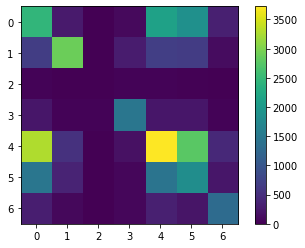

1436.0

In [188]:
import matplotlib.pyplot as plt
plt.imshow(relations_beifall)
plt.colorbar()
plt.show()
relations_beifall[5,4]

In [65]:

from sklearn.cluster import SpectralClustering
mat = relations_beifall
SpectralClustering(2).fit_predict(mat)

/Users/seven/venv/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/seven/venv/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([0, 0, 1, 0, 0, 0, 0], dtype=int32)

[1. 1. 1. 1. 1. 1. 1.]
[1.12189735 0.6356425  0.53182542 0.47998578 0.09513322 0.04195081
 0.00546739]


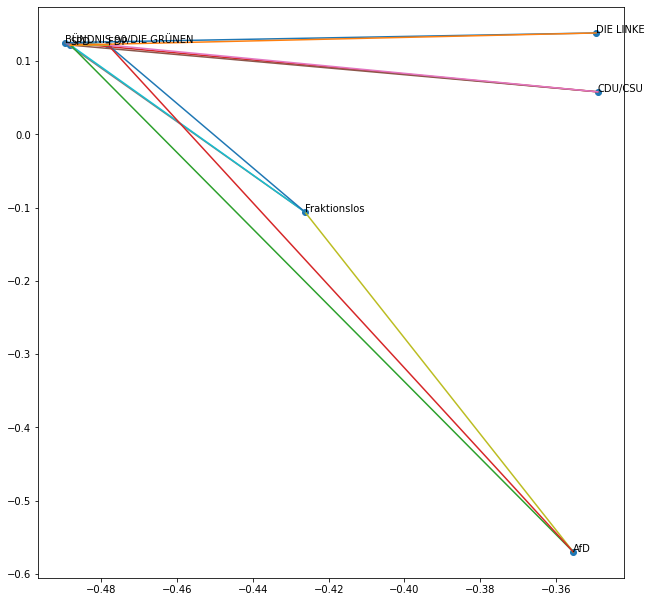

In [197]:
from numpy import linalg as LA
from sklearn.preprocessing import normalize

#for ix,pi in enumerate(party_names):
#    relations_beifall[ix-1,ix-1] = 0

normed_matrix = normalize(relations_beifall, axis=1, norm='l1')

print(sum(normed_matrix.T))

#mu = normed_matrix.mean(axis=1)
#data = normed_matrix - mu
# data = (data - mu)/data.std(axis=0)  # Uncommenting this reproduces mlab.PCA results
eigenvectors, eigenvalues, V = np.linalg.svd(normed_matrix.T, full_matrices=False)
#eigenvectors, eigenvalues, V = np.linalg.svd(data, full_matrices=False)

#eigenvalues , eigenvectors = LA.eig(normed_matrix.T)

projected_data = np.dot(normed_matrix, eigenvectors)
#sum(normed_matrix.T)
print(eigenvalues)

x = projected_data[:,0]
y = projected_data[:,1]

fig, ax = plt.subplots()
ax.scatter(x,y)
for i, txt in enumerate(party_names):
    ax.annotate(txt, (x[i], y[i]))
    
for i1, p1 in enumerate(party_names):
    for i2, p2 in enumerate(party_names):
        if normed_matrix[i1,i2] > 0.1:
            #pass
            ax.plot([x[i1],x[i2]],[y[i1], y[i2]])

#plt.plot(x, y)
    
fig.set_size_inches(10.5, 10.5)    
plt.show()


/Users/seven/venv/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


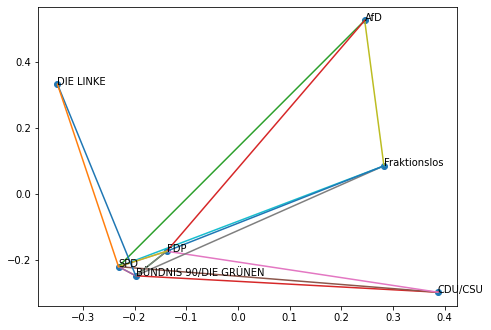

In [200]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(normed_matrix.T)
X_transformed.shape


x = X_transformed[:,0]
y = X_transformed[:,1]

fig, ax = plt.subplots()
ax.scatter(x,y)
for i, txt in enumerate(party_names):
    ax.annotate(txt, (x[i], y[i]))
    
for i1, p1 in enumerate(party_names):
    for i2, p2 in enumerate(party_names):
        if normed_matrix[i1,i2] > 0.1:
            ax.plot([x[i1],x[i2]],[y[i1], y[i2]])

#plt.plot(x, y)
    
fig.set_size_inches(7.5, 5.5)    
plt.show()


In [48]:
# draw as graph
nodes = []
for px,party in enumerate(party_names):
    nodes.append({
                'id': px+1,
                'name': party
                })    


graph = {
    'directed': False,
    'graph': 'semant_graph',
    'links': [],
    'nodes': nodes
}

for i, node_i in enumerate(graph['nodes']):
    for j, node_j in enumerate(graph['nodes']):
        #if i < j:
        source = node_i['id']
        target = node_j['id']
        weight = relations_beifall[i, j]

        link = {
            'source': source,
            'target': target,
            'weight': weight
        }
        graph['links'].append(link)

#graph





In [50]:

def render_comment_graph(graph):

    #lv = '//' if properties['edgevisibility'] else ''
    #parts = '//' if not properties['particles'] else ''
    #dm = '//' if not properties['darkmode'] else ''

    d3graph = {
        'nodes': graph['nodes'],
        'links': graph['links']
    }

    htmlcode = f"""<head>
        <style>
            body {{margin: 0;}}
            h3 {{text-align: center;}}
            .center {{
              display: block;
              margin-left: auto;
              margin-right: auto;
            }}
        </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="Logo.png" height="150" width="300" class="center">
    <h3>DebSearch ist eine statistische Website, welche die aktuelle Legislaturperiode</h3>
    <h3>in verschiedenen Kategorieren auswertet und visualisiert.</h3>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel(name)
            .nodeRelSize(1)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """

    return { 'graph': htmlcode }

html_graph = render_comment_graph(graph)

with open(f'./comment_network.html', 'w') as f:
    f.write(html_graph['graph'])


In [21]:


nParties = 7

relations_beifall = np.zeros((nParties,nParties))

relations_beifall[1,0]


0.0

In [180]:
zähler = collections.Counter(all_comments_beifall_zuruf).most_common()
#zähler